### This script builds a model that predicts contract length and value for pending RFA's. 

Steps are as follows:
1. Read in data; scrape historical contract data from Capfriendly & import player stats from Evolving-Hockey.
2. Prepare training dataset by cleaning contract data and engineering desired features.
3. Calculate weighted average of player stats for up to 3 seasons before signing their RFA contract; add as columns to training dataset.
4. Build & implement term model: choose hyperparameters, fit model, make predictions on training data, and evaluate model performance.
5. Build & implement cap hit model: re-weight stats, choose hyperparameters, fit model (including term as a feature), make predictions on training data, and evaluate model performance.
6. Calculate the flatcap adjustment factor; the average gap between actual and predicted contracts for the summer of 2020 using the model that's blind to COVID.
7. Apply to 2021 RFA dataset; scrape & preprocess data, add weighted stat values, make predictions using the term model, expand the dataset so each row becomes 8 rows (one with each term value so we can predict cap hit for each possible term), and make predictions using the cap hit model & flat-cap adjustment factor.
8. Format output to be easily understood by management/stakeholders.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta
import unidecode 

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


pd.set_option('display.max_columns', None)

### 1. Read in data; scrape historical contract data from Capfriendly & import player stats from Evolving-Hockey.

#### Capfriendly Contract Data 

In [2]:
lookup_year_list = ['2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008']

initial_contract_expiry_df = pd.DataFrame() 
for year in lookup_year_list:
    for weight in np.arange(150, 260):
        url = 'https://www.capfriendly.com/browse/active/' + year + '?display=birthday,weight,heightcm,draft,signing-status,expiry-year,aav,length,signing-date,arbitration,extension&hide=team,clauses,goalie-stats&limits=weight-' + str(weight) + '-' + str(weight) + ',gp-1-90'
        w = requests.get(url)
        df_list = pd.read_html(w.text)
        table = df_list[0]
        table['SEASON'] = str(int(year)-1) + '-' + str(year)[-2:]          
        
        if len(table) >= 50:
            lh_url = 'https://www.capfriendly.com/browse/active/' + year + '/weight/all/all/all/desc/left?display=birthday,weight,heightcm,draft,signing-status,expiry-year,aav,length,signing-date,arbitration,extension&hide=team,clauses,goalie-stats&limits=weight-' + str(weight) + '-' + str(weight) + ',gp-1-90'
            w = requests.get(lh_url)
            df_list = pd.read_html(w.text)
            lh_table = df_list[0]
            lh_table['SEASON'] = str(int(year)-1) + '-' + str(year)[-2:]          
            initial_contract_expiry_df = pd.concat([initial_contract_expiry_df, lh_table])
            if len(lh_table) >= 50:
                display('error: ' + lh_url)
                display(lh_table)
            
            rh_url = 'https://www.capfriendly.com/browse/active/' + year + '/weight/all/all/all/desc/right?display=birthday,weight,heightcm,draft,signing-status,expiry-year,aav,length,signing-date,arbitration,extension&hide=team,clauses,goalie-stats&limits=weight-' + str(weight) + '-' + str(weight) + ',gp-1-90'
            w = requests.get(rh_url)
            df_list = pd.read_html(w.text)
            rh_table = df_list[0]
            rh_table['SEASON'] = str(int(year)-1) + '-' + str(year)[-2:]
            initial_contract_expiry_df = pd.concat([initial_contract_expiry_df, rh_table])
            if len(rh_table) >= 50:
                display('error: ' + rh_url)
                display(rh_table)
        else:
            initial_contract_expiry_df = pd.concat([initial_contract_expiry_df, table])

#### Evolving-Hockey Player Data 

In [3]:
def deal_with_aho_capfriendly(df):
    if ('Sebastian Aho' in df['PLAYER']) & ('D' in df['POS']):
        return df['PLAYER'].replace('Sebastian Aho', 'Sebastian Aho (D)')
    elif ('Sebastian Aho' in df['PLAYER']) & ('C' in df['POS']):
        return df['PLAYER'].replace('Sebastian Aho', 'Sebastian Aho (C)')
    else:
        return df['PLAYER']

def deal_with_aho_evolvinghockey(df):
    if ('Sebastian Aho' in df['PLAYER']) & ('D' not in df['POS']):
        return df['PLAYER'].replace('Sebastian Aho', 'Sebastian Aho (C)')
    else:
        return df['PLAYER']

In [5]:
on_ice_df = pd.read_csv('EH_NHL On Ice 5v5.csv')
on_ice_df['Season'] = on_ice_df.apply(lambda x: '20' + str(x['Season']), axis=1) 

on_ice_df.rename({'Player': 'PLAYER', 'Position': 'POS'}, axis=1, inplace=True)
on_ice_df['PLAYER'] = on_ice_df.apply(deal_with_aho_evolvinghockey, axis=1)
on_ice_df['ID'] = on_ice_df['PLAYER'] + ' ' + on_ice_df['Season']

on_ice_cf_dict = dict(zip(on_ice_df['ID'], on_ice_df['CF']))
on_ice_ca_dict = dict(zip(on_ice_df['ID'], on_ice_df['CA']))
on_ice_gf_dict = dict(zip(on_ice_df['ID'], on_ice_df['GF']))
on_ice_ga_dict = dict(zip(on_ice_df['ID'], on_ice_df['GA']))

In [6]:
box_score_df = pd.read_csv('EH_NHL Box Score All Sits.csv')
box_score_df['TOI/GP'] = box_score_df['TOI'] / box_score_df['GP'] 
box_score_df.rename(columns={"Draft Yr": "Draft_Yr"}, inplace=True)
box_score_df['Years_Since_Draft'] = box_score_df.apply(lambda x: int('20' + x.Season[3:]) - x.Draft_Yr, axis=1)

box_score_df['Season'] = box_score_df.apply(lambda x: '20' + str(x['Season']), axis=1) 

box_score_df.rename({'Player': 'PLAYER', 'Position': 'POS'}, axis=1, inplace=True)
box_score_df['PLAYER'] = box_score_df.apply(deal_with_aho_evolvinghockey, axis=1)
box_score_df['ID'] = box_score_df['PLAYER'] + ' ' + box_score_df['Season']
box_score_df['Birthday'] = pd.to_datetime(box_score_df['Birthday'])
birthday_dict = dict(zip(box_score_df['ID'], box_score_df['Birthday']))
unique_player_list = list(dict.fromkeys(box_score_df['PLAYER'].tolist()))

box_score_df['On-Ice CF'] = box_score_df['ID'].map(on_ice_cf_dict) 
box_score_df['On-Ice CA'] = box_score_df['ID'].map(on_ice_ca_dict) 
box_score_df['On-Ice C Diff'] = box_score_df['On-Ice CF'] - box_score_df['On-Ice CA']
box_score_df['On-Ice GF'] = box_score_df['ID'].map(on_ice_gf_dict) 
box_score_df['On-Ice GA'] = box_score_df['ID'].map(on_ice_ga_dict) 
box_score_df['On-Ice G Diff'] = box_score_df['On-Ice GF'] - box_score_df['On-Ice GA']
box_score_df['Avg_Game_Score'] = ((0.75 * box_score_df['G']) + (0.7 * box_score_df['A1']) + (0.55 * box_score_df['A2']) + (0.075 * box_score_df['iSF']) + (0.05 * box_score_df['iBLK']) + (0.15 * box_score_df['iPEND2']) - (0.15 * box_score_df['iPENT2']) + (0.01 * box_score_df['FOW']) - (0.01 * box_score_df['FOL']) + (0.05 * box_score_df['On-Ice CF']) - (0.05 * box_score_df['On-Ice CA']) + (0.15 * box_score_df['On-Ice GF']) - (0.15 * box_score_df['On-Ice GA'])) / box_score_df['GP']
#https://hockey-graphs.com/2016/07/13/measuring-single-game-productivity-an-introduction-to-game-score/

box_score_df.sort_values('Avg_Game_Score', ascending=False, inplace=True)

box_score_df['G/GP'] = box_score_df['G'] / box_score_df['GP']
box_score_df['A1/GP'] = box_score_df['A1'] / box_score_df['GP']
box_score_df['Points/GP'] = box_score_df['Points'] / box_score_df['GP']
box_score_df['iCF/GP'] = box_score_df['iCF'] / box_score_df['GP']
box_score_df['ixG/GP'] = box_score_df['ixG'] / box_score_df['GP']
box_score_df['iBLK/GP'] = box_score_df['iBLK'] / box_score_df['GP']
box_score_df['iPEND2/GP'] = box_score_df['iPEND2'] / box_score_df['GP']
box_score_df['iPENT2/GP'] = box_score_df['iPENT2'] / box_score_df['GP']
box_score_df['GIVE/GP'] = box_score_df['GIVE'] / box_score_df['GP']
box_score_df['TAKE/GP'] = box_score_df['TAKE'] / box_score_df['GP']
box_score_df['On-Ice C Diff/GP'] = box_score_df['On-Ice C Diff'] / box_score_df['GP']
box_score_df['On-Ice G Diff/GP'] = box_score_df['On-Ice G Diff'] / box_score_df['GP']

temp = box_score_df.copy()
temp = temp.loc[temp['Season'] == '2020-21']
player_team_2021_dict = dict(zip(temp['PLAYER'], temp['Team']))
player_team_2021_dict

box_score_df = box_score_df.loc[box_score_df['GP'] >= 3]
box_score_df.head(3)

,PLAYER,EH_ID,API ID,Season,Team,POS,Shoots,Birthday,Age,Draft_Yr,Draft Rd,Draft Ov,GP,TOI,G,A1,A2,Points,iSF,iFF,iCF,ixG,Sh%,FSh%,xFSh%,iBLK,GIVE,TAKE,iHF,iHA,iPENT2,iPEND2,iPENT5,iPEND5,iPEN±,FOW,FOL,FO±,TOI/GP,Years_Since_Draft,ID,On-Ice CF,On-Ice CA,On-Ice C Diff,On-Ice GF,On-Ice GA,On-Ice G Diff,Avg_Game_Score,G/GP,A1/GP,Points/GP,iCF/GP,ixG/GP,iBLK/GP,iPEND2/GP,iPENT2/GP,GIVE/GP,TAKE/GP,On-Ice C Diff/GP,On-Ice G Diff/GP
1756,Alex Ovechkin,ALEX.OVECHKIN,8471214,2009-10,WSH,L,R,1985-09-17,23,2004,1.0,1.0,72,1569.42,50,37,22,109,368,540,822,38.97,13.59,9.26,7.22,20,76,66,185,119,22,33,3,0,8,10,12,-2,21.797500,6,Alex Ovechkin 2009-10,1348.71,950.29,398.42,77.26,32.88,44.38,1.837611,0.694444,0.513889,1.513889,11.416667,0.541250,0.277778,0.458333,0.305556,1.055556,0.916667,5.533611,0.616389
11663,Connor McDavid,CONNOR.MCDAVID,8478402,2020-21,EDM,C,L,1997-01-13,23,2015,1.0,1.0,56,1240.60,33,50,22,105,200,257,314,25.07,16.50,12.84,9.75,24,47,36,61,89,10,29,0,0,19,316,322,-6,22.153571,6,Connor McDavid 2020-21,1020.12,824.41,195.71,62.61,48.17,14.44,1.835562,0.589286,0.892857,1.875000,5.607143,0.447679,0.428571,0.517857,0.178571,0.839286,0.642857,3.494821,0.257857
23,Alex Ovechkin,ALEX.OVECHKIN,8471214,2007-08,WSH,L,R,1985-09-17,21,2004,1.0,1.0,82,1894.73,65,36,11,112,446,645,907,44.57,14.57,10.08,6.91,44,93,68,220,130,20,56,0,0,36,7,11,-4,23.106463,4,Alex Ovechkin 2007-08,1474.05,1052.77,421.28,78.38,47.97,30.41,1.788238,0.792683,0.439024,1.365854,11.060976,0.543537,0.536585,0.682927,0.243902,1.134146,0.829268,5.137561,0.370854


### 2. Prepare training dataset by cleaning contract data and engineering desired features.

In [7]:
name_map_dict = {'Mitchell Marner': 'Mitch Marner', # to ensure naming conventions are consistent across Capfriendly / Evolving-Hockey
                'Joshua Morrissey': 'Josh Morrissey',
                'Michael Matheson': 'Mike Matheson',
                'James van Riemsdyk': 'James Van Riemsdyk',
                'Alexander Semin': 'Alex Semin',
                'Matthew Carle': 'Matt Carle',
                'Alexander Radulov': 'Alex Radulov',
                'Alexander Edler': 'Alex Edler',
                'Danny DeKeyser': 'Danny Dekeyser',
                'Alexander Wennberg': 'Alex Wennberg',
                'Toby Enstrom': 'Tobias Enstrom',
                'TJ Brodie': 'Tj Brodie',
                'Alexander Steen': 'Alex Steen',
                'Martin St. Louis': 'Martin St  Louis',
                'Christopher Tanev': 'Chris Tanev',
                'Alex DeBrincat': 'Alex Debrincat',
                'Alexandre Burrows': 'Alex Burrows',
                'Nikolai Kulemin': 'Nikolay Kulemin',
                'Jean-Pierre Dumont': 'j-p Dumont',
                'Pierre-Alexandre Parenteau': 'P.A. Parenteau',
                'Evgeni Dadonov': 'Evgeny Dadonov',
                'Zachary Werenski': 'Zach Werenski',
                'Alexander Kerfoot': 'Alex Kerfoot',
                'Vaclav Prospal': 'Vinny Prospal',
                'Dylan DeMelo': 'Dylan Demelo',
                'Alexei Kovalev': 'Alex Kovalev',
                'Freddy Modin': 'Fredrik Modin',
                'Anthony Deangelo': 'Tony Deangelo',
                'Maxime Talbot': 'Max Talbot',
                'Jake DeBrusk': 'Jake Debrusk',
                'Steven Reinprecht': 'Steve Reinprecht',
                'Greg de Vries': 'Greg De Vries',
                'Trevor van Riemsdyk': 'Trevor Van Riemsdyk',
                'Nikolai Antropov': 'Nik Antropov',
                'Matthew Benning': 'Matt Benning',
                "Matt D'Agostini": "Matt D'agostini",
                'Alexander Burmistrov': 'Alex Burmistrov',
                'Alexander Frolov': 'Alex Frolov',
                'Samuel Blais': 'Sammy Blais',
                'Zachary Sanford': 'Zach Sanford',
                'Yevgeni Medvedev': 'Evgeny Medvedev',
                'Nicholas Paul': 'Nick Paul',
                'Joshua Brown': 'Josh Brown',
                'Alexandre Carrier': 'Alex Carrier',
                'Nikolai Zherdev': 'Nikolay Zherdev',
                'Michael Vecchione': 'Mike Vecchione',
                'Daniel Carcillo': 'Dan Carcillo',
                'Paul LaDue': 'Paul Ladue',
                'Alexandre Picard': 'Alex Picard',
                'Jeff Hamilton': 'Jeffrey Hamilton',
                'Nicolas Petan': 'Nic Petan',
                'C.J. Suess': 'Cj Suess',
                'Chris VandeVelde': 'Chris Vandevelde',
                'Daniel Renouf': 'Dan Renouf',
                'T.J. Brennan': 'Tj Brennan',
                'Michael Liambas': 'Mike Liambas',
                'T.J. Tynan': 'Tj Tynan',
                'Philip Varone': 'Phil Varone',
                'TJ Galiardi': 'T.J. Galiardi',
                "Will O'Neill": "will O'Neill",
                'Chris DiDomenico': 'Chris Didomenico',
                'Drew LeBlanc': 'Drew Leblanc',
                'Jean Philippe Cote': 'Jean-Philippe Cote',
                'Alexandre Bolduc': 'Alex Bolduc',
                'Jean-Francois Jacques': 'j-f jacques',
                'Alexander Barabanov': 'Alex Barabanov',
                "Danny O'Regan": "Daniel O'Regan",
                'Nick Merkley': 'Nicholas Merkley',
                "Jerry D'Amigo": "Jerry D'amigo",
                'Sergei Kalinin': 'Sergey Kalinin',
                'Nicholas Baptiste': 'Nick Baptiste',
                'Mike York': 'Michael York',
                'AJ Greer': 'A.J. Greer',
                'Alexandre Grenier': 'Alex Grenier',
                'Cristoval Nieves': 'Boo Nieves',
                'Thomas DiPauli': 'Thomas Di Pauli',
                'Alexander Volkov': 'Alex Volkov',
                'Louis Belpedio': 'Louie Belpedio',
                'JC Lipon': 'Jc Lipon',
                'Michael Liambas': 'Mike Liambas',
                'Brandon DeFazio': 'Brandon Defazio',
                'Maxime Comtois': 'Max Comtois',
                'Connor Mackey': 'Connor MacKey',
                'Alexandre Texier': 'Alex Texier',
                'Nicholas Caamano': 'Nick Caamano',
                'Michael Mcleod': 'Michael McLeod',
                'Tim Gettinger': 'Timothy Gettinger',
                'Erik Gustafsson': 'Erik Gustafsson (D)',
                'Colin White': 'Colin White (C)'}

salary_cap_dict = {'2007-08': 50300000,
                   '2008-09': 56700000,
                   '2009-10': 56800000,
                   '2010-11': 59400000,
                   '2011-12': 64300000,
                   '2012-13': 64300000,
                   '2013-14': 64300000,
                   '2014-15': 69000000,
                   '2015-16': 71400000,
                   '2016-17': 73000000,
                   '2017-18': 75000000,
                   '2018-19': 79500000,
                   '2019-20': 81500000,
                   '2020-21': 81500000,
                   '2021-22': 81500000}

league_min_dict = {'2007-08': 475000,
                   '2008-09': 475000,
                   '2009-10': 500000,
                   '2010-11': 500000,
                   '2011-12': 525000,
                   '2012-13': 525000,
                   '2013-14': 550000,
                   '2014-15': 550000,
                   '2015-16': 575000,
                   '2016-17': 575000,
                   '2017-18': 650000,
                   '2018-19': 650000,
                   '2019-20': 700000,
                   '2020-21': 700000,
                   '2021-22': 750000}

In [8]:
rfa_contract_df = initial_contract_expiry_df.copy()

rfa_contract_df = rfa_contract_df.loc[rfa_contract_df['POS'] != 'G'] # Exclude goalies
rfa_contract_df = rfa_contract_df.loc[rfa_contract_df['SIGNING'] != 'ELC'] # Limit to only RFA contracts
rfa_contract_df = rfa_contract_df.loc[rfa_contract_df['SIGNING'] != 'UFA'] # Limit to only RFA contracts

for col in list(rfa_contract_df):
    rfa_contract_df = rfa_contract_df[~rfa_contract_df[col].isin(["Deceased (25)", "Deceased (35)"])]

temp_list = []
for name in rfa_contract_df['PLAYER']:
    temp_list.append(unidecode.unidecode(name))
rfa_contract_df['PLAYER'] = temp_list # Remove accents

rfa_contract_df['PLAYER'] = rfa_contract_df.apply(deal_with_aho_capfriendly, axis=1)
rfa_contract_df['PLAYER'] = rfa_contract_df.apply(lambda x: x['PLAYER'][x['PLAYER'].find('.')+2:], axis=1)
rfa_contract_df['PLAYER'] = rfa_contract_df['PLAYER'].replace(name_map_dict)  

rfa_contract_df.reset_index(inplace=True)
signing_list = []
for index, row in rfa_contract_df.iterrows():
    if (row['PLAYER'] + ' ' + row['SIGNING DATE']) not in signing_list:
        signing_list.append(row['PLAYER'] + ' ' + row['SIGNING DATE'])
    else:
        rfa_contract_df = rfa_contract_df.drop(index, axis=0)

rfa_contract_df['SHOOTS_R'] = rfa_contract_df['HANDED'].map({'Right': 1, 'Left': 0}) 

for col in ['AAV', 'CAP HIT']: 
    rfa_contract_df[col] = rfa_contract_df[col].str[1:].str.replace(',','').astype('int')
for col in ['AGE', 'LENGTH', 'EXP. YEAR', 'HEIGHT', 'WEIGHT']:
    rfa_contract_df[col] = pd.to_numeric(rfa_contract_df[col])
for col in ['DATE OF BIRTH', 'SIGNING DATE']:
    rfa_contract_df[col] = pd.to_datetime(rfa_contract_df[col])

rfa_contract_df['C'] = rfa_contract_df.apply(lambda x: int('C' in x.POS), axis=1) # Create binary variables for each position (C/W/D)
rfa_contract_df['W'] = rfa_contract_df.apply(lambda x: int('W' in x.POS), axis=1)
rfa_contract_df['D'] = rfa_contract_df.apply(lambda x: int('D' in x.POS), axis=1)    

def determine_starting_season(df):
    temp1 = df['EXP. YEAR'] - df['LENGTH']
    temp2 = int(str(temp1)[-2:])+1
    if temp2 >= 10:
        return str(temp1) + '-' + str(temp2)
    else:
        return str(temp1) + '-0' + str(temp2) #to avoid 2008-9
        
rfa_contract_df['STARTINGSEASON'] = rfa_contract_df.apply(determine_starting_season, axis=1) # To calculate each player's age at the date their contract started
rfa_contract_df['STARTINGSEASONYEAR'] = rfa_contract_df.apply(lambda x: int(x['STARTINGSEASON'][:4]), axis=1)
rfa_contract_df['MONTHJULY1'] = 7
rfa_contract_df['DAYJULY1'] = 1
rfa_contract_df['STARTINGSEASONJULY1'] = pd.to_datetime(dict(year=rfa_contract_df.STARTINGSEASONYEAR, month=rfa_contract_df.MONTHJULY1, day=rfa_contract_df.DAYJULY1))
rfa_contract_df['AGE_STARTINGSEASONJULY1'] = rfa_contract_df.apply(lambda x: relativedelta(x['STARTINGSEASONJULY1'], x['DATE OF BIRTH']).years, axis=1) 
for col in ['STARTINGSEASONYEAR', 'MONTHJULY1', 'DAYJULY1', 'STARTINGSEASONJULY1']:
    rfa_contract_df.drop(col, inplace=True, axis=1)

def determine_flat_cap(df): # Include binary variable for whether contract was signed pre- or post-COVID
    return 1 if df['STARTINGSEASON'] in ['2020-21', '2021-22'] else 0
rfa_contract_df['FLATCAP'] = rfa_contract_df.apply(determine_flat_cap, axis=1)

def identify_age_tier(df): # Create ordinal variable based on age
    if df['AGE_STARTINGSEASONJULY1'] <= 22:
        return 1
    if df['AGE_STARTINGSEASONJULY1'] <= 23:
        return 2
    if df['AGE_STARTINGSEASONJULY1'] <= 24:
        return 3
    if df['AGE_STARTINGSEASONJULY1'] <= 25:
        return 4
    else:
        return 5
rfa_contract_df['AGE TIER'] = rfa_contract_df.apply(identify_age_tier, axis=1)

rfa_contract_df['LENGTH'] = rfa_contract_df['LENGTH'].replace({15:8, 14:8, 13:8, 12:8, 11:8, 10:8, 9:8}) # Code all contracts of 8 years or longer as 8 years

for col in ['EXTENSION', 'ARB. ELIG', 'ARB. REQ']: # Include arbitration eligibility as model feature
    rfa_contract_df[col] = rfa_contract_df[col].map({'✔': 1})
    rfa_contract_df[col] = rfa_contract_df[col].fillna(0)
    
rfa_contract_df['DRAFTBINARY'] = rfa_contract_df.apply(lambda x: 0 if x['DRAFTED'] == '-' else 1, axis=1) # Draft variables: whether they were drafted (binary), which round, and overall position
rfa_contract_df['DRAFTOVR'] = rfa_contract_df.apply(lambda x: int(x['DRAFTED'].split('-')[0][:-1]) if x['DRAFTBINARY'] == 1 else 300, axis=1)
rfa_contract_df['DRAFTRD'] = rfa_contract_df.apply(lambda x: int(x['DRAFTED'].split('-')[1][7:-1]) if x['DRAFTBINARY'] == 1 else 10, axis=1)

rfa_contract_df['CAP_HIT_PCT'] = rfa_contract_df['CAP HIT'] / rfa_contract_df['STARTINGSEASON'].map(salary_cap_dict) # Target of model will be % of cap rather than nominal dollar figure

rfa_contract_df.rename({'GP': 'GP_', 'G': 'G_'}, inplace=True, axis=1)

for index, row in rfa_contract_df.iterrows():
    if row.PLAYER == 'Nikita Gusev': # Gusev signed a non-ELC RFA contract with zero NHL stats
        rfa_contract_df.drop(index, axis=0, inplace=True)

rfa_contract_df.head(5)

# Note - ignore error message

ValueError: Unable to parse string "Deceased (31)" at position 949

### 3. Calculate weighted average of player stats for up to 3 seasons before signing their RFA contract; add as columns to training dataset.

In [8]:
season_in_order_list = ['2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14',
                        '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22']

def calculate_weights(stat_series, term_binary):
    if len(stat_series) == 0:
        return 'N/A'
    elif len(stat_series) == 1:
        return np.array([1])
    elif len(stat_series) == 2:
        return np.array([5/23, 18/23]) if term_binary == True else np.array([10/29, 19/29]) # Weights borrowed from Evolving-Hockey methodology given time constraints. Ideally, their approach of using a grid search to find optimal weights would be replicated.
    elif len(stat_series) == 3:
        return np.array([3/26, 5/26, 18/26]) if term_binary == True else np.array([9/38, 10/38, 19/38])
    
def calculate_weighted_stat(contract_df, box_score_starting_df, box_score_stats, season_in_order_list, term_binary): # Define function to weight stats
        
    for ind, row in contract_df.iterrows():
        
        relevant_seasons = []
        for i in [1,2,3]:

            if season_in_order_list.index(row.STARTINGSEASON) - i >= 0: #Don't let index go from 0 to -1
                relevant_seasons.append(season_in_order_list[season_in_order_list.index(row.STARTINGSEASON) - i])    

        if len(relevant_seasons) == 1:
            if relevant_seasons[0] == '2006-07':
                contract_df = contract_df.drop(ind, axis=0)
        
        box_score_lookup_df = box_score_starting_df.copy()
        box_score_lookup_df = box_score_lookup_df.loc[box_score_lookup_df.PLAYER == row.PLAYER]
        box_score_lookup_df = box_score_lookup_df.loc[box_score_lookup_df['Season'].isin(relevant_seasons)]
        box_score_lookup_df.sort_values(["Season"], inplace=True)
        
        for stat in box_score_stats:
            stat_value = box_score_lookup_df[stat]
            if len(box_score_lookup_df) > 0:
                weights = calculate_weights(stat_value.array, True)
                contract_df.loc[ind, stat] = np.multiply(stat_value.array, weights).sum() if type(weights) != str else float("NaN")
            else:
                contract_df.loc[ind, stat] = 0

    return contract_df

In [12]:
box_score_stats_to_lookup = ['GP', 'TOI/GP', 'G', 'A1', 'Points', 'iCF', 'ixG', 'iBLK', 'iPEND2', 'iPENT2', 'GIVE', 'TAKE', 'Avg_Game_Score', 'On-Ice C Diff', 'On-Ice G Diff'] # List of stats to weight

for stat in box_score_stats_to_lookup:
    rfa_contract_df[stat] = ""
    
term_binary = True
rfa_contract_df = calculate_weighted_stat(rfa_contract_df, box_score_df, box_score_stats_to_lookup, season_in_order_list, term_binary) # Call above function

rfa_contract_df.dropna(inplace=True)

scaler = StandardScaler()
for col in box_score_stats_to_lookup + ['DRAFTRD', 'DRAFTOVR', 'HEIGHT', 'WEIGHT']: # Scale continuous features
    rfa_contract_df[col] = scaler.fit_transform(rfa_contract_df[[col]].values)[:, 0]

rfa_contract_df.sort_values('Points', ascending=False, inplace=True)
rfa_contract_df.head(5)

(1713, 58)

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,ARB. ELIG,ARB. REQ,LENGTH,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,SEASON,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff
385,1105.0,0.0,Nikita Kucherov,26.0,1993-06-17,-1.370973,-1.048855,RW,Left,58 - Round 2 - 2011 (TBL),68.0,33,52,85,1.25,26,210,0.16,18:51,1.0,2018-07-10,1.0,0.0,8.0,RFA,UFA,2027.0,9500000.0,9500000.0,"$12,000,000",2019-20,0.0,0.0,1.0,0.0,2019-20,26.0,0.0,5.0,1.0,-0.484409,-0.614047,0.116564,1.383412,1.160813,4.462066,6.201428,5.640108,3.248919,2.826179,-0.139901,1.928275,2.097887,3.687238,2.731932,4.111202,2.141730,3.448810
357,999.0,0.0,Alex Ovechkin,34.0,1985-09-17,2.352020,0.935240,"LW, RW",Right,1 - Round 1 - 2004 (WSH),45.0,24,18,42,0.93,-7,182,0.13,19:30,1.0,2008-01-10,0.0,0.0,8.0,RFA,UFA,2021.0,9538462.0,9538462.0,"$10,000,000",2020-21,1.0,0.0,1.0,0.0,2008-09,22.0,0.0,1.0,1.0,-1.066362,-0.937399,0.168227,1.431354,1.718435,7.679764,4.626628,5.322929,6.765550,5.568486,0.393381,5.339297,1.520456,4.181337,3.305862,5.562116,4.678619,4.320082
2450,7168.0,0.0,Evgeni Malkin,26.0,1986-07-31,-0.373743,0.935240,C,Left,2 - Round 1 - 2004 (PIT),60.0,23,49,72,1.20,10,191,0.12,20:03,1.0,2008-07-02,0.0,0.0,5.0,RFA,UFA,2014.0,8700000.0,8700000.0,"$7,500,000",2013-14,0.0,1.0,0.0,0.0,2009-10,22.0,0.0,1.0,1.0,-1.056152,-0.937399,0.153169,1.431354,1.571915,4.082338,6.013457,5.293660,3.456767,4.061674,0.246347,6.057368,3.940123,3.447177,4.628611,3.290654,-1.684880,3.178247
137,429.0,0.0,Connor McDavid,23.0,1997-01-13,-0.506707,-0.146993,C,Left,1 - Round 1 - 2015 (EDM),56.0,33,72,105,1.88,21,200,0.17,22:09,1.0,2017-07-05,0.0,0.0,8.0,RFA,UFA,2026.0,12500000.0,12500000.0,"$14,000,000",2020-21,0.0,1.0,0.0,0.0,2018-19,21.0,0.0,1.0,1.0,-1.066362,-0.937399,0.157233,1.274839,1.382845,3.871060,4.827164,4.623840,2.334252,4.031423,0.226656,3.233513,0.106747,2.258881,5.059812,3.520552,0.955674,2.790745
589,1674.0,2.0,Nicklas Backstrom,31.0,1987-11-23,0.357559,-0.146993,C,Left,4 - Round 1 - 2006 (WSH),61.0,12,42,54,0.89,-1,132,0.09,19:01,1.0,2010-05-17,0.0,0.0,8.0,RFA,UFA,2020.0,6700000.0,6700000.0,"$8,000,000",2019-20,0.0,1.0,0.0,0.0,2010-11,22.0,0.0,1.0,1.0,-1.035733,-0.937399,0.112795,1.431354,1.213468,2.911308,5.287218,4.358446,1.851064,2.295808,0.752844,1.253902,1.475655,1.976230,2.823464,3.629581,4.017861,4.620389


### 4. Build & implement term model: choose hyperparameters, fit model, make predictions on training data, and evaluate model performance.

In [585]:
term_features = ['C', 'W', 'D', 'AGE TIER', 'SHOOTS_R', 
                 'FLATCAP', 'DRAFTOVR', 'DRAFTRD', 'ARB. ELIG', 'HEIGHT', 'WEIGHT',
                 'GP', 'TOI/GP', 'G', 'A1', 'Points', 'iCF', 'ixG', 'iBLK', 'iPEND2', 'iPENT2', 'GIVE', 'TAKE', 'Avg_Game_Score', 'On-Ice C Diff', 'On-Ice G Diff']

for feature in term_features:
    if feature in list(rfa_contract_df):
        rfa_contract_df[feature] = rfa_contract_df[feature].astype(float)

all_rfa_term_X = rfa_contract_df.loc[:, term_features]
all_rfa_term_y = rfa_contract_df.loc[:, 'LENGTH'] # target is the contract term

all_rfa_term_clf = RandomForestClassifier(random_state=0,      # RandomForestClassifier algorithm chosen given nature of data & performance compared to other algorithms
                             n_jobs=-1,                        # These hyperparameters were chosen using sklearn's GridSearchCV function
                             class_weight = 'balanced', 
                             criterion = 'gini',
                             min_samples_leaf = 2,
                             bootstrap = True,
                             oob_score = True, 
                             n_estimators = 130,
                             max_samples = 0.26,
                             max_depth = 12,
                             max_features = 18)
 
all_rfa_term_clf.fit(all_rfa_term_X, all_rfa_term_y)

#clf_grid_search = GridSearchCV(estimator=all_rfa_term_clf, param_grid = {}, scoring='balanced_accuracy', cv=5)
#term_clf = clf_grid_search.fit(all_rfa_term_X, all_rfa_term_y)
#display(term_clf.best_params_)

RandomForestClassifier(class_weight='balanced', max_depth=12, max_features=18,
                       max_samples=0.26, min_samples_leaf=2, n_estimators=130,
                       n_jobs=-1, oob_score=True, random_state=0)

In [586]:
rfa_contract_df['PRED_LENGTH'] = all_rfa_term_clf.predict(rfa_contract_df[term_features]) # Predict term
rfa_contract_df_pred_prob = all_rfa_term_clf.predict_proba(rfa_contract_df[term_features]) # Estimate probability of each term option (1-8 years)
rfa_contract_df['PROB_1YR'] = rfa_contract_df_pred_prob[:,0]
rfa_contract_df['PROB_2YR'] = rfa_contract_df_pred_prob[:,1]
rfa_contract_df['PROB_3YR'] = rfa_contract_df_pred_prob[:,2]
rfa_contract_df['PROB_4YR'] = rfa_contract_df_pred_prob[:,3]
rfa_contract_df['PROB_5YR'] = rfa_contract_df_pred_prob[:,4]
rfa_contract_df['PROB_6YR'] = rfa_contract_df_pred_prob[:,5]
rfa_contract_df['PROB_7YR'] = rfa_contract_df_pred_prob[:,6]
rfa_contract_df['PROB_8YR'] = rfa_contract_df_pred_prob[:,7]
rfa_contract_df.head(5)

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,ARB. ELIG,ARB. REQ,LENGTH,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,SEASON,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR
385,1105.0,0.0,Nikita Kucherov,26.0,1993-06-17,-1.370973,-1.048855,RW,Left,58 - Round 2 - 2011 (TBL),68.0,33,52,85,1.25,26,210,0.16,18:51,1.0,2018-07-10,1.0,0.0,8.0,RFA,UFA,2027.0,9500000.0,9500000.0,"$12,000,000",2019-20,0.0,0.0,1.0,0.0,2019-20,26.0,0.0,5.0,1.0,-0.484409,-0.614047,0.116564,1.383412,1.160813,4.462066,6.201428,5.640108,3.248919,2.826179,-0.139901,1.928275,2.097887,3.687238,2.731932,4.111202,2.141730,3.448810,8.0,0.005759,0.014363,0.017147,0.065467,0.224652,0.127087,0.115704,0.429821
357,999.0,0.0,Alex Ovechkin,34.0,1985-09-17,2.352020,0.935240,"LW, RW",Right,1 - Round 1 - 2004 (WSH),45.0,24,18,42,0.93,-7,182,0.13,19:30,1.0,2008-01-10,0.0,0.0,8.0,RFA,UFA,2021.0,9538462.0,9538462.0,"$10,000,000",2020-21,1.0,0.0,1.0,0.0,2008-09,22.0,0.0,1.0,1.0,-1.066362,-0.937399,0.168227,1.431354,1.718435,7.679764,4.626628,5.322929,6.765550,5.568486,0.393381,5.339297,1.520456,4.181337,3.305862,5.562116,4.678619,4.320082,8.0,0.001159,0.026165,0.018551,0.039241,0.205795,0.199998,0.139349,0.369741
2450,7168.0,0.0,Evgeni Malkin,26.0,1986-07-31,-0.373743,0.935240,C,Left,2 - Round 1 - 2004 (PIT),60.0,23,49,72,1.20,10,191,0.12,20:03,1.0,2008-07-02,0.0,0.0,5.0,RFA,UFA,2014.0,8700000.0,8700000.0,"$7,500,000",2013-14,0.0,1.0,0.0,0.0,2009-10,22.0,0.0,1.0,1.0,-1.056152,-0.937399,0.153169,1.431354,1.571915,4.082338,6.013457,5.293660,3.456767,4.061674,0.246347,6.057368,3.940123,3.447177,4.628611,3.290654,-1.684880,3.178247,5.0,0.001244,0.021627,0.019011,0.038003,0.353876,0.161259,0.117465,0.287517
137,429.0,0.0,Connor McDavid,23.0,1997-01-13,-0.506707,-0.146993,C,Left,1 - Round 1 - 2015 (EDM),56.0,33,72,105,1.88,21,200,0.17,22:09,1.0,2017-07-05,0.0,0.0,8.0,RFA,UFA,2026.0,12500000.0,12500000.0,"$14,000,000",2020-21,0.0,1.0,0.0,0.0,2018-19,21.0,0.0,1.0,1.0,-1.066362,-0.937399,0.157233,1.274839,1.382845,3.871060,4.827164,4.623840,2.334252,4.031423,0.226656,3.233513,0.106747,2.258881,5.059812,3.520552,0.955674,2.790745,8.0,0.000667,0.014889,0.020404,0.028821,0.283143,0.193622,0.097418,0.361036
589,1674.0,2.0,Nicklas Backstrom,31.0,1987-11-23,0.357559,-0.146993,C,Left,4 - Round 1 - 2006 (WSH),61.0,12,42,54,0.89,-1,132,0.09,19:01,1.0,2010-05-17,0.0,0.0,8.0,RFA,UFA,2020.0,6700000.0,6700000.0,"$8,000,000",2019-20,0.0,1.0,0.0,0.0,2010-11,22.0,0.0,1.0,1.0,-1.035733,-0.937399,0.112795,1.431354,1.213468,2.911308,5.287218,4.358446,1.851064,2.295808,0.752844,1.253902,1.475655,1.976230,2.823464,3.629581,4.017861,4.620389,8.0,0.002831,0.029602,0.027301,0.068152,0.201452,0.102965,0.143332,0.424364


(1713, 67)

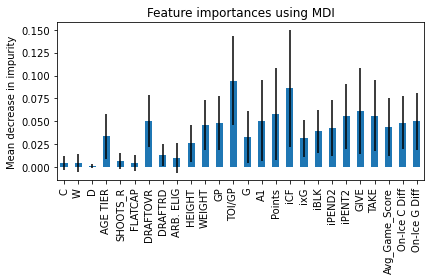

In [587]:
importances = all_rfa_term_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in all_rfa_term_clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=term_features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

'Accuracy: 0.783420899007589'

'Balanced accuracy: 0.8029448628927272'

array([[[ 897,  145],
        [ 126,  545]],

       [[ 968,  153],
        [ 141,  451]],

       [[1546,   10],
        [  57,  100]],

       [[1601,   19],
        [  18,   75]],

       [[1629,   17],
        [  11,   56]],

       [[1619,   18],
        [   7,   69]],

       [[1679,    0],
        [  10,   24]],

       [[1681,    9],
        [   1,   22]]], dtype=int64)

'ACTUAL LENGTH'

<AxesSubplot:>

1.0    671
2.0    592
3.0    157
4.0     93
6.0     76
5.0     67
7.0     34
8.0     23
Name: LENGTH, dtype: int64

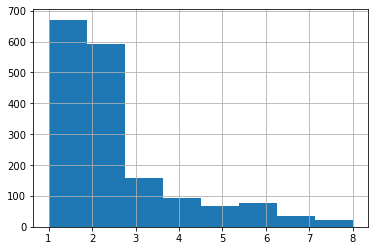

'PREDICTED LENGTH'

<AxesSubplot:>

1.0    690
2.0    604
3.0    110
4.0     94
6.0     87
5.0     73
8.0     31
7.0     24
Name: PRED_LENGTH, dtype: int64

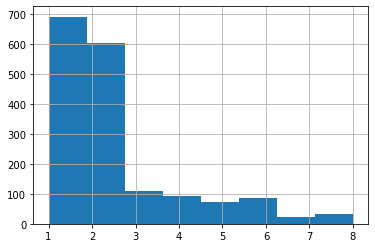

In [588]:
accuracy = accuracy_score(rfa_contract_df['LENGTH'], rfa_contract_df['PRED_LENGTH'])
display('Accuracy: ' + str(accuracy))

balanced_accuracy = balanced_accuracy_score(rfa_contract_df['LENGTH'], rfa_contract_df['PRED_LENGTH'])
display('Balanced accuracy: ' + str(balanced_accuracy))

display(multilabel_confusion_matrix(rfa_contract_df['LENGTH'], rfa_contract_df['PRED_LENGTH']))

display('ACTUAL LENGTH')
display(rfa_contract_df['LENGTH'].hist(bins=8))
display(rfa_contract_df['LENGTH'].value_counts())
plt.show()
plt.close()

display('PREDICTED LENGTH')
display(rfa_contract_df['PRED_LENGTH'].hist(bins=8))
display(rfa_contract_df['PRED_LENGTH'].value_counts())
plt.show()
plt.close()

### 5. Build & implement cap hit model: re-weight stats, choose hyperparameters, fit model (including term as a feature), make predictions on training data, and evaluate model performance.

In [589]:
for stat in box_score_stats_to_lookup:
    rfa_contract_df[stat] = ""
    
term_binary = False
rfa_contract_df = calculate_weighted_stat(rfa_contract_df, box_score_df, box_score_stats_to_lookup, season_in_order_list, term_binary)

scaler = StandardScaler()
for col in box_score_stats_to_lookup + ['DRAFTRD', 'DRAFTOVR', 'HEIGHT', 'WEIGHT']:
    rfa_contract_df[col] = scaler.fit_transform(rfa_contract_df[[col]].values)[:, 0]

rfa_contract_df.head(1)

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,ARB. ELIG,ARB. REQ,LENGTH,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,SEASON,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR
385,1105.0,0.0,Nikita Kucherov,26.0,1993-06-17,-1.370973,-1.048855,RW,Left,58 - Round 2 - 2011 (TBL),68.0,33,52,85,1.25,26,210,0.16,18:51,1.0,2018-07-10,1.0,0.0,8.0,RFA,UFA,2027.0,9500000.0,9500000.0,"$12,000,000",2019-20,0.0,0.0,1.0,0.0,2019-20,26.0,0.0,5.0,1.0,-0.484409,-0.614047,0.116564,1.383412,1.160813,4.462066,6.201428,5.640108,3.248919,2.826179,-0.139901,1.928275,2.097887,3.687238,2.731932,4.111202,2.14173,3.44881,8.0,0.005759,0.014363,0.017147,0.065467,0.224652,0.127087,0.115704,0.429821


In [590]:
cap_features = ['C', 'W', 'D', 'AGE TIER', 'SHOOTS_R', 
                #'FLATCAP', # omitted; adjustment factor calculated independently 
                'DRAFTOVR', 'DRAFTRD', 'ARB. ELIG', 'LENGTH', 'HEIGHT', 'WEIGHT',
                'GP', 'TOI/GP', 'G', 'A1', 'Points', 'iCF', 'ixG', 'iBLK', 'iPEND2', 'iPENT2', 'GIVE', 'TAKE', 'Avg_Game_Score', 'On-Ice C Diff', 'On-Ice G Diff']

for feature in cap_features:
    if feature in list(rfa_contract_df):
        rfa_contract_df[feature] = rfa_contract_df[feature].astype(float)

all_rfa_cap_X = rfa_contract_df.loc[:, cap_features]
all_rfa_cap_y = rfa_contract_df.loc[:, 'CAP_HIT_PCT']

all_rfa_cap_reg = MLPRegressor(random_state=0,     # Multi-layer perceptron regressor algorithm chosen given nature of data & performance compared to other algorithms
                       activation='relu',
                       hidden_layer_sizes = (60,),
                       max_iter = 500,
                       solver = 'lbfgs',
                       warm_start = True,
                       alpha = 0.1)

all_rfa_cap_reg.fit(all_rfa_cap_X, all_rfa_cap_y)

#all_rfa_reg_grid_search = GridSearchCV(estimator=all_rfa_cap_reg, param_grid = {}, scoring= 'neg_mean_squared_error', cv=5)
#all_rfa_cap_reg = all_rfa_reg_grid_search.fit(all_rfa_cap_X, all_rfa_cap_y)    
#display(all_rfa_cap_reg.best_params_)


In [592]:
def calculate_pred_cap_hit(df):
    return df['PRED_CAP_HIT_PCT'] * salary_cap_dict[df['STARTINGSEASON']]

def clip_league_min(df):
    league_min_pct = league_min_dict[df['STARTINGSEASON']]/salary_cap_dict[df['STARTINGSEASON']]
    return df['PRED_CAP_HIT_PCT'] if df['PRED_CAP_HIT_PCT'] >= league_min_pct else league_min_pct 

rfa_contract_df['PRED_CAP_HIT_PCT'] = all_rfa_cap_reg.predict(rfa_contract_df[cap_features])
rfa_contract_df['PRED_CAP_HIT_PCT'] = rfa_contract_df.apply(clip_league_min, axis=1) #Enforce league-min
rfa_contract_df['PRED_CAP_HIT'] = rfa_contract_df.apply(calculate_pred_cap_hit, axis=1) 
rfa_contract_df['CAP_PCT_DELTA'] = rfa_contract_df['PRED_CAP_HIT_PCT'] - rfa_contract_df['CAP_HIT_PCT']
rfa_contract_df['ABS_CAP_PCT_DELTA'] = abs(rfa_contract_df['CAP_PCT_DELTA'])
rfa_contract_df.head(3)

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,ARB. ELIG,ARB. REQ,LENGTH,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,SEASON,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR,PRED_CAP_HIT_PCT,PRED_CAP_HIT,CAP_PCT_DELTA,ABS_CAP_PCT_DELTA
385,1105.0,0.0,Nikita Kucherov,26.0,1993-06-17,-1.370973,-1.048855,RW,Left,58 - Round 2 - 2011 (TBL),68.0,33,52,85,1.25,26,210,0.16,18:51,1.0,2018-07-10,1.0,0.0,8.0,RFA,UFA,2027.0,9500000.0,9500000.0,"$12,000,000",2019-20,0.0,0.0,1.0,0.0,2019-20,26.0,0.0,5.0,1.0,-0.484409,-0.614047,0.116564,1.383412,1.160813,4.462066,6.201428,5.640108,3.248919,2.826179,-0.139901,1.928275,2.097887,3.687238,2.731932,4.111202,2.141730,3.448810,8.0,0.005759,0.014363,0.017147,0.065467,0.224652,0.127087,0.115704,0.429821,0.151198,1.232262e+07,0.034633,0.034633
357,999.0,0.0,Alex Ovechkin,34.0,1985-09-17,2.352020,0.935240,"LW, RW",Right,1 - Round 1 - 2004 (WSH),45.0,24,18,42,0.93,-7,182,0.13,19:30,1.0,2008-01-10,0.0,0.0,8.0,RFA,UFA,2021.0,9538462.0,9538462.0,"$10,000,000",2020-21,1.0,0.0,1.0,0.0,2008-09,22.0,0.0,1.0,1.0,-1.066362,-0.937399,0.168227,1.431354,1.718435,7.679764,4.626628,5.322929,6.765550,5.568486,0.393381,5.339297,1.520456,4.181337,3.305862,5.562116,4.678619,4.320082,8.0,0.001159,0.026165,0.018551,0.039241,0.205795,0.199998,0.139349,0.369741,0.181364,1.028331e+07,0.013137,0.013137
2450,7168.0,0.0,Evgeni Malkin,26.0,1986-07-31,-0.373743,0.935240,C,Left,2 - Round 1 - 2004 (PIT),60.0,23,49,72,1.20,10,191,0.12,20:03,1.0,2008-07-02,0.0,0.0,5.0,RFA,UFA,2014.0,8700000.0,8700000.0,"$7,500,000",2013-14,0.0,1.0,0.0,0.0,2009-10,22.0,0.0,1.0,1.0,-1.056152,-0.937399,0.153169,1.431354,1.571915,4.082338,6.013457,5.293660,3.456767,4.061674,0.246347,6.057368,3.940123,3.447177,4.628611,3.290654,-1.684880,3.178247,5.0,0.001244,0.021627,0.019011,0.038003,0.353876,0.161259,0.117465,0.287517,0.122784,6.974129e+06,-0.030385,0.030385


,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,ARB. ELIG,ARB. REQ,TRUE_LENGTH,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,SEASON,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR,LENGTH,PRED_CAP_HIT_PCT,PRED_CAP_HIT,CAP_PCT_DELTA,ABS_CAP_PCT_DELTA,ADJ_PRED_CAP_HIT,ADJ_PRED_CAP_HIT_PCT,ADJ_CAP_PCT_DELTA,ABS_ADJ_CAP_PCT_DELTA
385,1105.0,0.0,Nikita Kucherov,26.0,1993-06-17,-1.370973,-1.048855,RW,Left,58 - Round 2 - 2011 (TBL),68.0,33,52,85,1.25,26,210,0.16,18:51,1.0,2018-07-10,1.0,0.0,8.0,RFA,UFA,2027.0,9500000.0,9500000.0,"$12,000,000",2019-20,0.0,0.0,1.0,0.0,2019-20,26.0,0.0,5.0,1.0,-0.484409,-0.614047,0.116564,1.383412,1.160813,4.462066,6.201428,5.640108,3.248919,2.826179,-0.139901,1.928275,2.097887,3.687238,2.731932,4.111202,2.14173,3.44881,8.0,0.005759,0.014363,0.017147,0.065467,0.224652,0.127087,0.115704,0.429821,1,0.099565,8.114588e+06,-0.016999,0.016999,8.751193e+06,0.107377,-0.009188,0.009188
385,1105.0,0.0,Nikita Kucherov,26.0,1993-06-17,-1.370973,-1.048855,RW,Left,58 - Round 2 - 2011 (TBL),68.0,33,52,85,1.25,26,210,0.16,18:51,1.0,2018-07-10,1.0,0.0,8.0,RFA,UFA,2027.0,9500000.0,9500000.0,"$12,000,000",2019-20,0.0,0.0,1.0,0.0,2019-20,26.0,0.0,5.0,1.0,-0.484409,-0.614047,0.116564,1.383412,1.160813,4.462066,6.201428,5.640108,3.248919,2.826179,-0.139901,1.928275,2.097887,3.687238,2.731932,4.111202,2.14173,3.44881,8.0,0.005759,0.014363,0.017147,0.065467,0.224652,0.127087,0.115704,0.429821,2,0.117681,9.590967e+06,0.001116,0.001116,9.167783e+06,0.112488,-0.004076,0.004076
385,1105.0,0.0,Nikita Kucherov,26.0,1993-06-17,-1.370973,-1.048855,RW,Left,58 - Round 2 - 2011 (TBL),68.0,33,52,85,1.25,26,210,0.16,18:51,1.0,2018-07-10,1.0,0.0,8.0,RFA,UFA,2027.0,9500000.0,9500000.0,"$12,000,000",2019-20,0.0,0.0,1.0,0.0,2019-20,26.0,0.0,5.0,1.0,-0.484409,-0.614047,0.116564,1.383412,1.160813,4.462066,6.201428,5.640108,3.248919,2.826179,-0.139901,1.928275,2.097887,3.687238,2.731932,4.111202,2.14173,3.44881,8.0,0.005759,0.014363,0.017147,0.065467,0.224652,0.127087,0.115704,0.429821,3,0.134118,1.093064e+07,0.017554,0.017554,9.584372e+06,0.117600,0.001035,0.001035


'R2: 0.9169321295900639'

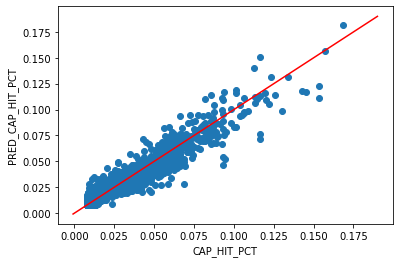

In [593]:
display('R2: ' + str(r2_score(rfa_contract_df['CAP_HIT_PCT'], rfa_contract_df['PRED_CAP_HIT_PCT'])))

fig, ax = plt.subplots()
plt.scatter(rfa_contract_df['CAP_HIT_PCT'], rfa_contract_df['PRED_CAP_HIT_PCT'])
plt.xlabel('CAP_HIT_PCT')
plt.ylabel('PRED_CAP_HIT_PCT')

lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'r-', zorder=2)

plt.show()

### 6. Calculate the flatcap adjustment factor; the average gap between actual and predicted contracts for the summer of 2020 using the model that's blind to COVID.

<ipython-input-595-e8e6ea38963b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRED_CAP_HIT_PCT'] = all_rfa_cap_reg.predict(df[cap_features])
<ipython-input-595-e8e6ea38963b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRED_CAP_HIT_PCT'] = df.apply(clip_league_min, axis=1) #Enforce league-min
<ipython-input-595-e8e6ea38963b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

'R2: 0.9292609905846871'

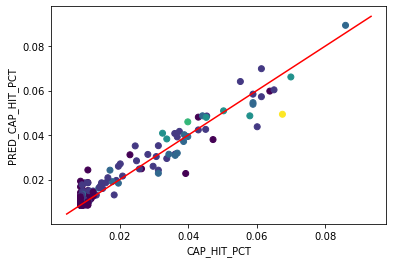

array([ 56, 144,  51,  24,   5,   0,   7,   0])

1.0833602954336452

array([56, 72, 17,  6,  1,  0,  1,  0])

array([1.12904878, 1.11005748, 1.01925019, 1.04111177, 1.15226751,
       0.        , 0.73137379, 0.        ])

1.102015916583954

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,ARB. ELIG,ARB. REQ,LENGTH,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,SEASON,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_CAP_HIT_PCT,PRED_CAP_HIT,PRED_CAP_HIT_RATIO,CAP_PCT_DELTA,ABS_CAP_PCT_DELTA
79,268.0,1.0,Mathew Barzal,23.0,1997-05-26,-0.905599,-0.507738,C,Right,16 - Round 1 - 2015 (NYI),55.0,17,28,45,0.82,15,134,0.13,18:43,0.0,2021-01-09,0.0,0.0,3.0,RFA,RFA,2023.0,7000000.0,7000000.0,"$4,000,000",2020-21,1.0,1.0,0.0,0.0,2020-21,23.0,1.0,2.0,1.0,-0.913216,-0.937399,0.085890,1.076023,1.073632,1.658578,3.588558,2.589147,1.383993,1.878647,0.396928,2.337250,1.714592,4.796265,3.347917,1.969829,0.379977,0.476008,0.089301,7.278017e+06,1.039717,0.003411,0.003411
148,452.0,4.0,Sam Reinhart,24.0,1995-11-06,-0.440225,-0.146993,"C, RW",Right,2 - Round 1 - 2014 (BUF),54.0,25,15,40,0.74,-28,130,0.19,19:32,0.0,2020-10-25,1.0,1.0,1.0,RFA,RFA,2021.0,5200000.0,5200000.0,"$5,200,000",2020-21,1.0,1.0,1.0,0.0,2020-21,24.0,1.0,3.0,1.0,-1.056152,-0.937399,0.063804,1.101404,1.164512,2.077838,1.984268,2.006573,1.331947,1.823250,0.042195,0.488163,-0.226769,0.929775,0.564852,1.443277,0.170556,-0.066148,0.059756,4.870085e+06,0.936555,-0.004048,0.004048
139,432.0,3.0,Ryan Strome,26.0,1993-07-11,-0.506707,-0.146993,"C, RW",Right,5 - Round 1 - 2011 (NYI),56.0,14,35,49,0.88,6,128,0.11,18:16,0.0,2020-11-05,1.0,1.0,2.0,RFA,UFA,2022.0,4500000.0,4500000.0,"$4,000,000",2020-21,1.0,1.0,1.0,0.0,2020-21,26.0,1.0,5.0,1.0,-1.025523,-0.937399,0.055215,1.119735,0.889327,1.456524,2.544590,1.928896,0.874613,1.805609,-0.005103,-0.142702,1.839038,1.924447,0.896346,1.097453,-0.716378,1.981662,0.064060,5.220867e+06,1.160193,0.008845,0.008845


In [595]:
temp = rfa_contract_df.copy()

for col in ['PRED_LENGTH', 'PROB_1YR', 'PROB_2YR', 'PROB_3YR', 'PROB_4YR', 'PROB_5YR', 'PROB_6YR', 'PROB_7YR', 'PROB_8YR',
            'ITER_LENGTH', 'PRED_CAP_HIT_PCT', 'PRED_CAP_HIT', 'CAP_PCT_DELTA', 'ABS_CAP_PCT_DELTA']:
    if col in list(temp): 
        temp.drop(col, inplace=True, axis=1)

for stat in box_score_stats_to_lookup:
    temp[stat] = ""
    
term_binary = False
temp = calculate_weighted_stat(temp, box_score_df, box_score_stats_to_lookup, season_in_order_list, term_binary)

scaler = StandardScaler()
for col in box_score_stats_to_lookup + ['DRAFTRD', 'DRAFTOVR', 'HEIGHT', 'WEIGHT']:
    temp[col] = scaler.fit_transform(temp[[col]].values)[:, 0]

rfa_contract_df_fc_adj_train = temp.loc[temp['SIGNING DATE'] < '2020-03-12']
rfa_contract_df_fc_adj_test = temp.loc[temp['SIGNING DATE'] >= '2020-03-12']

#all_rfa_term_X_fc_adj = rfa_contract_df_fc_adj_train.loc[:, cap_features]
#all_rfa_term_y_fc_adj = rfa_contract_df_fc_adj_train.loc[:, 'CAP_HIT_PCT']

for df in [rfa_contract_df_fc_adj_train, rfa_contract_df_fc_adj_test]:
    df['PRED_CAP_HIT_PCT'] = all_rfa_cap_reg.predict(df[cap_features])
    df['PRED_CAP_HIT_PCT'] = df.apply(clip_league_min, axis=1) #Enforce league-min
    df['PRED_CAP_HIT'] = df.apply(calculate_pred_cap_hit, axis=1) 
    df['PRED_CAP_HIT_RATIO'] = df['PRED_CAP_HIT'] / df['CAP HIT']
    df['CAP_PCT_DELTA'] = df['PRED_CAP_HIT_PCT'] - df['CAP_HIT_PCT']
    df['ABS_CAP_PCT_DELTA'] = abs(df['CAP_PCT_DELTA'])

#rfa_contract_df_fc_adj_test.to_excel('20210708_rfa_contract_df_fc_adj_test.xlsx')

display('R2: ' + str(r2_score(rfa_contract_df_fc_adj_test['CAP_HIT_PCT'], rfa_contract_df_fc_adj_test['PRED_CAP_HIT_PCT'])))

fig, ax = plt.subplots()
plt.scatter(rfa_contract_df_fc_adj_test['CAP_HIT_PCT'], rfa_contract_df_fc_adj_test['PRED_CAP_HIT_PCT'], c=rfa_contract_df_fc_adj_test['LENGTH'])
plt.xlabel('CAP_HIT_PCT')
plt.ylabel('PRED_CAP_HIT_PCT')

lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, 'r-', zorder=2)
plt.show()

terms = np.arange(1,9)
terms_count = [0, 0, 0, 0, 0, 0, 0, 0]
average_ratios = [0, 0, 0, 0, 0, 0, 0, 0]

for length in rfa_contract_df_fc_adj_test['LENGTH']:
    terms_count[int(length)-1] += 1
    
for length in rfa_contract_df_fc_adj_test['LENGTH'].unique():
    temp = rfa_contract_df_fc_adj_test.copy()
    temp = temp.loc[temp['LENGTH'] == length]
    average_ratios[int(length)-1] = temp['PRED_CAP_HIT_RATIO'].mean()
    
terms_count = np.array(terms_count)
average_ratios = np.array(average_ratios)
factor_array = terms * terms_count
fc_adj_factor = sum(average_ratios * factor_array) / sum(factor_array)

display(factor_array)
display(fc_adj_factor)
display(terms_count)
display(average_ratios)
display( sum(average_ratios * terms_count) / sum(terms_count))
rfa_contract_df_fc_adj_test.head(3)

In [596]:
def adjust_for_flatcap_hit(df):
    return df['PRED_CAP_HIT'] if df['SIGNING DATE'] >= datetime.strptime('2020-03-12', '%Y-%m-%d') else df['PRED_CAP_HIT'] / fc_adj_factor

def adjust_for_flatcap_pct(df):
    return df['PRED_CAP_HIT_PCT'] if df['SIGNING DATE'] >= datetime.strptime('2020-03-12', '%Y-%m-%d') else df['PRED_CAP_HIT_PCT'] / fc_adj_factor
    
for df in [rfa_contract_df, all_terms_rfa_contract_df]:
    df['ADJ_PRED_CAP_HIT'] = df.apply(adjust_for_flatcap_hit, axis=1)
    df['ADJ_PRED_CAP_HIT_PCT'] = df.apply(adjust_for_flatcap_pct, axis=1)
    df['ADJ_CAP_PCT_DELTA'] = df['ADJ_PRED_CAP_HIT_PCT'] - df['CAP_HIT_PCT']
    df['ABS_ADJ_CAP_PCT_DELTA'] = abs(df['ADJ_CAP_PCT_DELTA'])

rfa_contract_df.head(5)


,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,ARB. ELIG,ARB. REQ,LENGTH,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,SEASON,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR,PRED_CAP_HIT_PCT,PRED_CAP_HIT,CAP_PCT_DELTA,ABS_CAP_PCT_DELTA,ADJ_PRED_CAP_HIT,ADJ_PRED_CAP_HIT_PCT,ADJ_CAP_PCT_DELTA,ABS_ADJ_CAP_PCT_DELTA
385,1105.0,0.0,Nikita Kucherov,26.0,1993-06-17,-1.370973,-1.048855,RW,Left,58 - Round 2 - 2011 (TBL),68.0,33,52,85,1.25,26,210,0.16,18:51,1.0,2018-07-10,1.0,0.0,8.0,RFA,UFA,2027.0,9500000.0,9500000.0,"$12,000,000",2019-20,0.0,0.0,1.0,0.0,2019-20,26.0,0.0,5.0,1.0,-0.484409,-0.614047,0.116564,1.383412,1.160813,4.462066,6.201428,5.640108,3.248919,2.826179,-0.139901,1.928275,2.097887,3.687238,2.731932,4.111202,2.141730,3.448810,8.0,0.005759,0.014363,0.017147,0.065467,0.224652,0.127087,0.115704,0.429821,0.151198,1.232262e+07,0.034633,0.034633,1.137444e+07,0.139564,0.022999,0.022999
357,999.0,0.0,Alex Ovechkin,34.0,1985-09-17,2.352020,0.935240,"LW, RW",Right,1 - Round 1 - 2004 (WSH),45.0,24,18,42,0.93,-7,182,0.13,19:30,1.0,2008-01-10,0.0,0.0,8.0,RFA,UFA,2021.0,9538462.0,9538462.0,"$10,000,000",2020-21,1.0,0.0,1.0,0.0,2008-09,22.0,0.0,1.0,1.0,-1.066362,-0.937399,0.168227,1.431354,1.718435,7.679764,4.626628,5.322929,6.765550,5.568486,0.393381,5.339297,1.520456,4.181337,3.305862,5.562116,4.678619,4.320082,8.0,0.001159,0.026165,0.018551,0.039241,0.205795,0.199998,0.139349,0.369741,0.181364,1.028331e+07,0.013137,0.013137,9.492052e+06,0.167408,-0.000819,0.000819
2450,7168.0,0.0,Evgeni Malkin,26.0,1986-07-31,-0.373743,0.935240,C,Left,2 - Round 1 - 2004 (PIT),60.0,23,49,72,1.20,10,191,0.12,20:03,1.0,2008-07-02,0.0,0.0,5.0,RFA,UFA,2014.0,8700000.0,8700000.0,"$7,500,000",2013-14,0.0,1.0,0.0,0.0,2009-10,22.0,0.0,1.0,1.0,-1.056152,-0.937399,0.153169,1.431354,1.571915,4.082338,6.013457,5.293660,3.456767,4.061674,0.246347,6.057368,3.940123,3.447177,4.628611,3.290654,-1.684880,3.178247,5.0,0.001244,0.021627,0.019011,0.038003,0.353876,0.161259,0.117465,0.287517,0.122784,6.974129e+06,-0.030385,0.030385,6.437497e+06,0.113336,-0.039833,0.039833
137,429.0,0.0,Connor McDavid,23.0,1997-01-13,-0.506707,-0.146993,C,Left,1 - Round 1 - 2015 (EDM),56.0,33,72,105,1.88,21,200,0.17,22:09,1.0,2017-07-05,0.0,0.0,8.0,RFA,UFA,2026.0,12500000.0,12500000.0,"$14,000,000",2020-21,0.0,1.0,0.0,0.0,2018-19,21.0,0.0,1.0,1.0,-1.066362,-0.937399,0.157233,1.274839,1.382845,3.871060,4.827164,4.623840,2.334252,4.031423,0.226656,3.233513,0.106747,2.258881,5.059812,3.520552,0.955674,2.790745,8.0,0.000667,0.014889,0.020404,0.028821,0.283143,0.193622,0.097418,0.361036,0.156334,1.242857e+07,-0.000899,0.000899,1.147224e+07,0.144305,-0.012928,0.012928
589,1674.0,2.0,Nicklas Backstrom,31.0,1987-11-23,0.357559,-0.146993,C,Left,4 - Round 1 - 2006 (WSH),61.0,12,42,54,0.89,-1,132,0.09,19:01,1.0,2010-05-17,0.0,0.0,8.0,RFA,UFA,2020.0,6700000.0,6700000.0,"$8,000,000",2019-20,0.0,1.0,0.0,0.0,2010-11,22.0,0.0,1.0,1.0,-1.035733,-0.937399,0.112795,1.431354,1.213468,2.911308,5.287218,4.358446,1.851064,2.295808,0.752844,1.253902,1.475655,1.976230,2.823464,3.629581,4.017861,4.620389,8.0,0.002831,0.029602,0.027301,0.068152,0.201452,0.102965,0.143332,0.424364,0.139688,8.297442e+06,0.026893,0.026893,7.658986e+06,0.128939,0.016145,0.016145


### 7. Apply to 2021 RFA dataset; scrape & preprocess data, add weighted stat values, make predictions using the term model, expand the dataset so each row becomes 8 rows (one with each term value so we can predict cap hit for each possible term), and make predictions using the cap hit model & flat-cap adjustment factor.

In [242]:
team_list = ['ducks', 'coyotes', 'bruins', 'sabres', 'flames', 'hurricanes', 'blackhawks', 'avalanche',
             'bluejackets', 'stars', 'redwings', 'oilers', 'panthers', 'kings', 'wild', 'canadiens',
             'predators', 'devils', 'islanders', 'rangers', 'senators', 'flyers', 'penguins', 'sharks',
             'kraken', 'blues', 'lightning', 'mapleleafs', 'canucks', 'goldenknights', 'capitals', 'jets']


initial_fas_2021 = pd.DataFrame()

for team in team_list:        
    arb_url = 'https://www.capfriendly.com/browse/free-agents/2022/caphit/' + team + '?player-arbitration=eligible&display=birthday,weight,heightcm,draft,signing-status,expiry-year,aav,length,signing-date,extension&hide=team,clauses,goalie-stats&limits=gp-1-90'
    w = requests.get(arb_url)
    df_list = pd.read_html(w.text)
    arb_rfas = df_list[0]
    arb_rfas['ARB. ELIG'] = 1
    initial_fas_2021 = pd.concat([initial_fas_2021, arb_rfas])
    
    no_arb_url = 'https://www.capfriendly.com/browse/free-agents/2022/caphit/' + team + '?player-arbitration=ineligible&display=birthday,weight,heightcm,draft,signing-status,expiry-year,aav,length,signing-date,extension&hide=team,clauses,goalie-stats&limits=gp-1-90'
    w = requests.get(no_arb_url)
    df_list = pd.read_html(w.text)
    no_arb_rfas = df_list[0]
    no_arb_rfas['ARB. ELIG'] = 0
    initial_fas_2021 = pd.concat([initial_fas_2021, no_arb_rfas])

initial_rfas_2021 = initial_fas_2021.loc[(initial_fas_2021['EXPIRY'] == 'RFA') | (initial_fas_2021['EXPIRY'] == '10.2(c)')]
initial_rfas_2021

,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP,G,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,LENGTH,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,ARB. ELIG
0,1. Danton Heinen,25,"Jul 5, 1995",188,185,"LW, RW",Left,116 - Round 4 - 2014 (BOS),43,7,7,14,0.33,-9,76,0.09,14:45,NaN,"Jul 9, 2019",2,RFA,RFA,2021,"$2,800,000","$2,800,000","$2,775,000",1
1,2. Alexander Volkov,23,"Aug 2, 1997",191,185,"LW, RW",Left,48 - Round 2 - 2017 (TBL),37,7,6,13,0.35,1,35,0.2,11:38,NaN,"Dec 23, 2020",1,RFA,RFA,2021,"$700,000","$700,000","$700,000",1
3,4. Isac Lundeström,21,"Nov 6, 1999",187,183,"C, LW",Left,23 - Round 1 - 2018 (ANA),41,6,3,9,0.22,-9,52,0.12,15:14,NaN,"Aug 4, 2018",3,ELC,RFA,2021,"$925,000","$925,000","$925,000",0
4,5. Max Jones,23,"Feb 17, 1998",220,185,"LW, RW",Left,24 - Round 1 - 2016 (ANA),46,7,4,11,0.24,-9,77,0.09,14:10,NaN,"Aug 26, 2016",3,ELC,RFA,2021,"$863,333","$863,333","$832,500",0
5,6. Sam Steel,23,"Feb 3, 1998",189,180,C,Left,30 - Round 1 - 2016 (ANA),42,6,6,12,0.29,-7,42,0.14,14:31,NaN,"Dec 20, 2016",3,ELC,RFA,2021,"$863,333","$863,333","$832,500",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,4. Dylan Coghlan,23,"Feb 19, 1998",190,188,RD,Right,-,29,3,3,6,0.21,-3,31,0.10,13:29,NaN,"Sep 20, 2017",3,ELC,RFA,2021,"$715,556","$715,556","$700,000",0
0,1. Ilya Samsonov,24,"Feb 22, 1997",208,191,G,Left,22 - Round 1 - 2015 (WSH),19,-,-,-,-,-,-,-,-,NaN,"May 3, 2018",3,ELC,RFA,2021,"$925,000","$1,475,000","$925,000",1
0,1. Neal Pionk,25,"Jul 29, 1995",186,183,RD,Right,-,54,3,29,32,0.59,6,100,0.03,21:58,NaN,"Jul 21, 2019",2,RFA,RFA,2021,"$3,000,000","$3,000,000","$3,150,000",1
1,2. Andrew Copp,26,"Jul 8, 1994",206,185,"C, LW",Left,104 - Round 4 - 2013 (WPG),55,15,24,39,0.71,2,115,0.13,18:15,NaN,"Jul 23, 2019",2,RFA,RFA,2021,"$2,280,000","$2,280,000","$2,300,000",1


In [10]:
rfas_2021 = initial_rfas_2021.copy()

rfas_2021 = rfas_2021.loc[rfas_2021['POS'] != 'G']

rfas_2021.drop('LENGTH', inplace=True, axis=1)

temp_list = []
for name in rfas_2021['PLAYER']:
    temp_list.append(unidecode.unidecode(name))
rfas_2021['PLAYER'] = temp_list

rfas_2021['PLAYER'] = rfas_2021.apply(lambda x: x['PLAYER'][x['PLAYER'].find('.')+2:], axis=1)
rfas_2021['PLAYER'] = rfas_2021['PLAYER'].replace(name_map_dict)

rfas_2021['TEAM'] = rfas_2021['PLAYER'].map(player_team_2021_dict)

rfas_2021.reset_index(inplace=True)

rfas_2021['SHOOTS_R'] = rfas_2021['HANDED'].map({'Right': 1, 'Left': 0}) 

for col in ['AAV', 'CAP HIT']: 
    rfas_2021[col] = rfas_2021[col].str[1:].str.replace(',','').astype('int')
for col in ['AGE', 'EXP. YEAR', 'HEIGHT', 'WEIGHT']:
    rfas_2021[col] = pd.to_numeric(rfas_2021[col])
for col in ['DATE OF BIRTH', 'SIGNING DATE']:
    rfas_2021[col] = pd.to_datetime(rfas_2021[col])

rfas_2021['C'] = rfas_2021.apply(lambda x: int('C' in x.POS), axis=1)
rfas_2021['W'] = rfas_2021.apply(lambda x: int('W' in x.POS), axis=1)
rfas_2021['D'] = rfas_2021.apply(lambda x: int('D' in x.POS), axis=1)    
        
rfas_2021['STARTINGSEASON'] = '2021-22'
rfas_2021['STARTINGSEASONYEAR'] = 2021
rfas_2021['MONTHJULY1'] = 7
rfas_2021['DAYJULY1'] = 1
rfas_2021['STARTINGSEASONJULY1'] = pd.to_datetime(dict(year=rfas_2021.STARTINGSEASONYEAR, month=rfas_2021.MONTHJULY1, day=rfas_2021.DAYJULY1))
rfas_2021['AGE_STARTINGSEASONJULY1'] = rfas_2021.apply(lambda x: relativedelta(x['STARTINGSEASONJULY1'], x['DATE OF BIRTH']).years, axis=1)
for col in ['STARTINGSEASONYEAR', 'MONTHJULY1', 'DAYJULY1', 'STARTINGSEASONJULY1']:
    rfas_2021.drop(col, inplace=True, axis=1)

rfas_2021['FLATCAP'] = 1

rfas_2021['AGE TIER'] = rfas_2021.apply(identify_age_tier, axis=1)

rfas_2021['DRAFTBINARY'] = rfas_2021.apply(lambda x: 0 if x['DRAFTED'] == '-' else 1, axis=1)
rfas_2021['DRAFTOVR'] = rfas_2021.apply(lambda x: int(x['DRAFTED'].split('-')[0][:-1]) if x['DRAFTBINARY'] == 1 else 300, axis=1)
rfas_2021['TOP5PICK'] = rfas_2021.apply(lambda x: 1 if x['DRAFTOVR'] in [1,2,3,4,5] else 0, axis=1)
rfas_2021['DRAFTRD'] = rfas_2021.apply(lambda x: int(x['DRAFTED'].split('-')[1][7:-1]) if x['DRAFTBINARY'] == 1 else 10, axis=1)

rfas_2021['CAP_HIT_PCT'] = rfas_2021['CAP HIT'] / rfas_2021['STARTINGSEASON'].map(salary_cap_dict) 

rfas_2021.rename({'GP': 'GP_', 'G': 'G_'}, inplace=True, axis=1)

rfas_2021.head(3)

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,ARB. ELIG,TEAM,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,TOP5PICK,DRAFTRD,CAP_HIT_PCT
0,0,0,Danton Heinen,25,1995-07-05,188,185,"LW, RW",Left,116 - Round 4 - 2014 (BOS),43,7,7,14,0.33,-9,76,0.09,14:45,NaN,2019-07-09,RFA,RFA,2021,2800000,2800000,"$2,775,000",1,ANA,0,0,1,0,2021-22,25,1,4,1,116,0,4,0.034356
1,1,1,Alex Volkov,23,1997-08-02,191,185,"LW, RW",Left,48 - Round 2 - 2017 (TBL),37,7,6,13,0.35,1,35,0.2,11:38,NaN,2020-12-23,RFA,RFA,2021,700000,700000,"$700,000",1,ANA/T.B,0,0,1,0,2021-22,23,1,2,1,48,0,2,0.008589
2,2,3,Isac Lundestrom,21,1999-11-06,187,183,"C, LW",Left,23 - Round 1 - 2018 (ANA),41,6,3,9,0.22,-9,52,0.12,15:14,NaN,2018-08-04,ELC,RFA,2021,925000,925000,"$925,000",0,ANA,0,1,1,0,2021-22,21,1,1,1,23,0,1,0.011350


In [609]:
for stat in box_score_stats_to_lookup:
    rfas_2021[stat] = ""
    
term_binary = True
rfas_2021 = calculate_weighted_stat(rfas_2021, box_score_df, box_score_stats_to_lookup, season_in_order_list, term_binary)

scaler = StandardScaler()
for col in box_score_stats_to_lookup + ['DRAFTRD', 'DRAFTOVR', 'HEIGHT', 'WEIGHT']:
    rfas_2021[col] = scaler.fit_transform(rfas_2021[[col]].values)[:, 0]

rfas_2021.sort_values('Points', ascending=False, inplace=True)
rfas_2021.head(3)

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,ARB. ELIG,TEAM,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,TOP5PICK,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0,MIN,0,0,1,0,2021-22,24,1,3,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210
108,114,0,Pavel Buchnevich,26,1995-04-17,0.199186,0.966181,"RW, LW",Left,75 - Round 3 - 2013 (NYR),54,20,28,48,0.89,12,120,0.17,18:43,NaN,2019-07-26,RFA,RFA,2021,3250000,3250000,"$3,500,000",1,NYR,0,0,1,0,2021-22,26,1,5,1,-0.235052,0,-0.220859,0.039877,1.300032,1.090630,2.659085,2.520905,2.809023,1.574558,1.974630,0.440947,1.527149,1.299083,2.277235,2.074457,1.775269,-0.494203,1.617979
43,46,8,Cale Makar,22,1998-10-30,-0.420848,-1.041468,RD,Right,4 - Round 1 - 2017 (COL),44,8,36,44,1.00,17,104,0.08,24:18,NaN,2019-04-14,ELC,RFA,2021,880833,2854166,"$925,000",0,COL,1,0,0,1,2021-22,22,1,1,1,-0.953616,1,-0.863356,0.010808,0.715896,2.406203,0.728291,3.858626,2.713369,1.871776,0.345955,1.140769,1.143475,0.167511,0.816895,2.178395,3.999809,5.201402,3.609811


In [610]:
for feature in term_features:
    if feature in list(rfas_2021):
        rfas_2021[feature] = rfas_2021[feature].astype(float)

rfas_2021['PRED_LENGTH'] = all_rfa_term_clf.predict(rfas_2021[term_features])
rfas_2021_pred_prob = all_rfa_term_clf.predict_proba(rfas_2021[term_features])
rfas_2021['PROB_1YR'] = rfas_2021_pred_prob[:,0]
rfas_2021['PROB_2YR'] = rfas_2021_pred_prob[:,1]
rfas_2021['PROB_3YR'] = rfas_2021_pred_prob[:,2]
rfas_2021['PROB_4YR'] = rfas_2021_pred_prob[:,3]
rfas_2021['PROB_5YR'] = rfas_2021_pred_prob[:,4]
rfas_2021['PROB_6YR'] = rfas_2021_pred_prob[:,5]
rfas_2021['PROB_7YR'] = rfas_2021_pred_prob[:,6]
rfas_2021['PROB_8YR'] = rfas_2021_pred_prob[:,7]
display(rfas_2021.head(5))
display(rfas_2021.shape)
#rfas_2021.to_excel('20210707_rfas_2021_v14.xlsx')

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,ARB. ELIG,TEAM,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,TOP5PICK,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057
108,114,0,Pavel Buchnevich,26,1995-04-17,0.199186,0.966181,"RW, LW",Left,75 - Round 3 - 2013 (NYR),54,20,28,48,0.89,12,120,0.17,18:43,NaN,2019-07-26,RFA,RFA,2021,3250000,3250000,"$3,500,000",1.0,NYR,0.0,0.0,1.0,0.0,2021-22,26,1.0,5.0,1,-0.235052,0,-0.220859,0.039877,1.300032,1.090630,2.659085,2.520905,2.809023,1.574558,1.974630,0.440947,1.527149,1.299083,2.277235,2.074457,1.775269,-0.494203,1.617979,5.0,0.028747,0.038429,0.061131,0.109250,0.305271,0.083194,0.110581,0.263396
43,46,8,Cale Makar,22,1998-10-30,-0.420848,-1.041468,RD,Right,4 - Round 1 - 2017 (COL),44,8,36,44,1.00,17,104,0.08,24:18,NaN,2019-04-14,ELC,RFA,2021,880833,2854166,"$925,000",0.0,COL,1.0,0.0,0.0,1.0,2021-22,22,1.0,1.0,1,-0.953616,1,-0.863356,0.010808,0.715896,2.406203,0.728291,3.858626,2.713369,1.871776,0.345955,1.140769,1.143475,0.167511,0.816895,2.178395,3.999809,5.201402,3.609811,8.0,0.007573,0.038727,0.069237,0.060655,0.249019,0.189126,0.133761,0.251902
31,34,6,Andrei Svechnikov,21,2000-03-26,0.075179,0.418640,"LW, RW",Left,2 - Round 1 - 2018 (CAR),55,15,27,42,0.76,1,147,0.10,17:32,NaN,2018-07-01,ELC,RFA,2021,925000,3575000,"$925,000",0.0,CAR,0.0,0.0,1.0,0.0,2021-22,21,1.0,1.0,1,-0.973858,1,-0.863356,0.011350,1.446819,0.875962,2.283405,1.931972,2.694570,2.674710,3.425584,0.086663,2.297878,4.337398,2.799615,1.458041,2.369780,3.119327,1.880788,5.0,0.003361,0.030427,0.070568,0.057020,0.269556,0.239562,0.111370,0.218136
17,18,0,Sam Reinhart,25,1995-11-06,0.013176,-0.128900,"C, RW",Right,2 - Round 1 - 2014 (BUF),54,25,15,40,0.74,-28,130,0.19,19:32,NaN,2020-10-25,RFA,RFA,2021,5200000,5200000,"$5,200,000",1.0,BUF,1.0,1.0,1.0,0.0,2021-22,25,1.0,4.0,1,-0.973858,1,-0.863356,0.063804,1.420316,1.491240,3.530947,1.679572,2.672315,1.914148,2.454214,0.600946,0.572576,0.016040,0.950744,0.932506,1.431559,-0.505070,-1.775327,5.0,0.079784,0.108453,0.087306,0.114289,0.196915,0.130832,0.125525,0.156896


(160, 66)

In [13]:
for stat in box_score_stats_to_lookup:
    rfas_2021[stat] = ""
    
term_binary = False
rfas_2021 = calculate_weighted_stat(rfas_2021, box_score_df, box_score_stats_to_lookup, season_in_order_list, term_binary)

scaler = StandardScaler()
for col in box_score_stats_to_lookup + ['DRAFTRD', 'DRAFTOVR', 'HEIGHT', 'WEIGHT']:
    rfas_2021[col] = scaler.fit_transform(rfas_2021[[col]].values)[:, 0]

rfas_2021.head(1)

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,ARB. ELIG,TEAM,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,TOP5PICK,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff
0,0,0,Danton Heinen,25,1995-07-05,-0.358845,-0.1289,"LW, RW",Left,116 - Round 4 - 2014 (BOS),43,7,7,14,0.33,-9,76,0.09,14:45,NaN,2019-07-09,RFA,RFA,2021,2800000,2800000,"$2,775,000",1,ANA,0,0,1,0,2021-22,25,1,4,1,0.179894,0,0.10039,0.034356,0.965683,0.306205,0.575122,0.703625,0.507241,0.833587,0.953183,0.728945,0.169535,-0.785861,0.149566,1.367159,0.353202,-0.30666,-0.141812


In [ ]:
def expand_to_all_term_lengths(df):
    temp = df.copy()
    temp['ITER_LENGTH'] = ""
    return_df = pd.DataFrame(columns=list(temp))
    for index, row in temp.iterrows():
        for i in range(1,9):
            row['ITER_LENGTH'] = str(i) #str(i)
            return_df = return_df.append(row) 
    return return_df

In [612]:
all_terms_rfas_2021 = expand_to_all_term_lengths(rfas_2021)

for df in [all_terms_rfas_2021]:
    if 'ITER_LENGTH' in list(df):
        df.rename(columns={"ITER_LENGTH": "LENGTH"}, inplace=True)
        
for df in [rfas_2021]:
    if 'PRED_LENGTH' in list(df):
        df.rename(columns={"PRED_LENGTH": "LENGTH"}, inplace=True)

all_terms_rfas_2021['LENGTH'] = all_terms_rfas_2021['LENGTH'].astype(float)
rfas_2021['LENGTH'] = rfas_2021['LENGTH'].astype(float)

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,ARB. ELIG,TEAM,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,TOP5PICK,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR,LENGTH
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.01135,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.18821,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,1.0
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.01135,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.18821,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,2.0
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.01135,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.18821,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,3.0


(1280, 67)

In [613]:
for df in [rfas_2021, all_terms_rfas_2021]:
    df['PRED_CAP_HIT_PCT'] = all_rfa_cap_reg.predict(df[cap_features])
    df['PRED_CAP_HIT_PCT'] = df.apply(clip_league_min, axis=1) #Enforce league-min
    df['PRED_CAP_HIT'] = df.apply(calculate_pred_cap_hit, axis=1) 
    df['ADJ_PRED_CAP_HIT'] = df['PRED_CAP_HIT'] / fc_adj_factor

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,ARB. ELIG,TEAM,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,TOP5PICK,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR,PRED_CAP_HIT_PCT,PRED_CAP_HIT,ADJ_PRED_CAP_HIT
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,0.092437,7.533586e+06,6.953907e+06
108,114,0,Pavel Buchnevich,26,1995-04-17,0.199186,0.966181,"RW, LW",Left,75 - Round 3 - 2013 (NYR),54,20,28,48,0.89,12,120,0.17,18:43,NaN,2019-07-26,RFA,RFA,2021,3250000,3250000,"$3,500,000",1.0,NYR,0.0,0.0,1.0,0.0,2021-22,26,1.0,5.0,1,-0.235052,0,-0.220859,0.039877,1.300032,1.090630,2.659085,2.520905,2.809023,1.574558,1.974630,0.440947,1.527149,1.299083,2.277235,2.074457,1.775269,-0.494203,1.617979,5.0,0.028747,0.038429,0.061131,0.109250,0.305271,0.083194,0.110581,0.263396,0.088447,7.208399e+06,6.653741e+06
43,46,8,Cale Makar,22,1998-10-30,-0.420848,-1.041468,RD,Right,4 - Round 1 - 2017 (COL),44,8,36,44,1.00,17,104,0.08,24:18,NaN,2019-04-14,ELC,RFA,2021,880833,2854166,"$925,000",0.0,COL,1.0,0.0,0.0,1.0,2021-22,22,1.0,1.0,1,-0.953616,1,-0.863356,0.010808,0.715896,2.406203,0.728291,3.858626,2.713369,1.871776,0.345955,1.140769,1.143475,0.167511,0.816895,2.178395,3.999809,5.201402,3.609811,8.0,0.007573,0.038727,0.069237,0.060655,0.249019,0.189126,0.133761,0.251902,0.122422,9.977355e+06,9.209637e+06
31,34,6,Andrei Svechnikov,21,2000-03-26,0.075179,0.418640,"LW, RW",Left,2 - Round 1 - 2018 (CAR),55,15,27,42,0.76,1,147,0.10,17:32,NaN,2018-07-01,ELC,RFA,2021,925000,3575000,"$925,000",0.0,CAR,0.0,0.0,1.0,0.0,2021-22,21,1.0,1.0,1,-0.973858,1,-0.863356,0.011350,1.446819,0.875962,2.283405,1.931972,2.694570,2.674710,3.425584,0.086663,2.297878,4.337398,2.799615,1.458041,2.369780,3.119327,1.880788,5.0,0.003361,0.030427,0.070568,0.057020,0.269556,0.239562,0.111370,0.218136,0.098133,7.997828e+06,7.382427e+06
17,18,0,Sam Reinhart,25,1995-11-06,0.013176,-0.128900,"C, RW",Right,2 - Round 1 - 2014 (BUF),54,25,15,40,0.74,-28,130,0.19,19:32,NaN,2020-10-25,RFA,RFA,2021,5200000,5200000,"$5,200,000",1.0,BUF,1.0,1.0,1.0,0.0,2021-22,25,1.0,4.0,1,-0.973858,1,-0.863356,0.063804,1.420316,1.491240,3.530947,1.679572,2.672315,1.914148,2.454214,0.600946,0.572576,0.016040,0.950744,0.932506,1.431559,-0.505070,-1.775327,5.0,0.079784,0.108453,0.087306,0.114289,0.196915,0.130832,0.125525,0.156896,0.089652,7.306643e+06,6.744426e+06
80,84,0,Kevin Fiala,24,1996-07-22,-0.048828,-1.406494,"LW, RW",Left,11 - Round 1 - 2014 (NSH),50,20,20,40,0.8,-2,162,0.12,16:53,NaN,2019-09-11,RFA,RFA,2021,3000000,3000000,"$3,500,000",1.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,-0.882772,0,-0.863356,0.036810,1.228677,0.738997,2.737056,2.108652,2.487918,2.681743,2.431223,-0.263049,2.036254,2.439565,2.388754,2.935859,2.008865,0.457237,0.475403,8.0,0.016184,0.048253,0.052958,0.053851,0.204405,0.178439,0.119948,0.325961,0.100549,8.194739e+06,7.564186e+06
53,56,1,Jakub Vrana,25,1996-02-28,0.075179,-0.493927,LW,Left,13 - Round 1 - 2014 (WSH),50,19,17,36,0.72,10,100,0.19,15:00,NaN,2019-07-16,RFA,RFA,2021,3350000,3350000,"$3,000,000",1.0,DET/WSH,0.0,0.0,1.0,0.0,2021-22,25,1.0,4.0,1,-0.862531,0,-0.863356,0.041104,1.273529,0.365941,2.914264,1.889905,2.303521,1.775499,1.685904,-0.409334,0.254386,0.274431,1.593446,1.367159,1.682459,0.216601,2.830424,2.0,0.079641,0.21

,index,Unnamed: 0,PLAYER,AGE,DATE OF BIRTH,WEIGHT,HEIGHT,POS,HANDED,DRAFTED,GP_,G_,A,P,P/GP,+/-,Sh,Sh%,TOI,EXTENSION,SIGNING DATE,SIGNING,EXPIRY,EXP. YEAR,CAP HIT,AAV,SALARY,ARB. ELIG,TEAM,SHOOTS_R,C,W,D,STARTINGSEASON,AGE_STARTINGSEASONJULY1,FLATCAP,AGE TIER,DRAFTBINARY,DRAFTOVR,TOP5PICK,DRAFTRD,CAP_HIT_PCT,GP,TOI/GP,G,A1,Points,iCF,ixG,iBLK,iPEND2,iPENT2,GIVE,TAKE,Avg_Game_Score,On-Ice C Diff,On-Ice G Diff,PRED_LENGTH,PROB_1YR,PROB_2YR,PROB_3YR,PROB_4YR,PROB_5YR,PROB_6YR,PROB_7YR,PROB_8YR,LENGTH,PRED_CAP_HIT_PCT,PRED_CAP_HIT,ADJ_PRED_CAP_HIT
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,1.0,0.044245,3.605998e+06,3.328531e+06
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,2.0,0.063492,5.174594e+06,4.776429e+06
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,3.0,0.082645,6.735564e+06,6.217289e+06
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,4.0,0.088228,7.190600e+06,6.637311e+06
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,5.0,0.092437,7.533586e+06,6.953907e+06
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.549429,0.630832,1.569969,1.620047,2.614379,-0.016342,2.188210,5.0,0.020656,0.044615,0.130583,0.096317,0.270334,0.194915,0.094523,0.148057,6.0,0.097419,7.939658e+06,7.328733e+06
81,85,4,Kirill Kaprizov,24,1997-04-26,-0.110831,-1.406494,"LW, RW",Left,135 - Round 5 - 2015 (MIN),55,27,24,51,0.93,10,157,0.17,18:17,NaN,2020-07-13,ELC,10.2(c),2021,925000,1387500,"$925,000",0.0,MIN,0.0,0.0,1.0,0.0,2021-22,24,1.0,3.0,1,0.372186,0,0.421639,0.011350,1.149167,1.167577,4.069659,2.764892,3.184175,2.456689,2.864745,-0.071051,3.5

### 8. Format output to be easily understood by management/stakeholders.

In [622]:
def lookup_rfas_2021(df, player, term, lookup_col_name):
    lookup_df = df.copy()
    lookup_df = lookup_df.loc[lookup_df['PLAYER'] == player]
    lookup_df = lookup_df.loc[lookup_df['LENGTH'] == term]
    if len(lookup_df) > 1:
        display('error')
    return float(lookup_df[lookup_col_name])
    
    
def prepare_player_output_row(prefunction_output_df, rfas_2021_row, descriptor_output_columns, term_prob_columns):
    
    row_return_dict = {}
    
    for col in descriptor_output_columns:
        row_return_dict[col] = rfas_2021_row[col]
        
    for i in range(len(term_prob_columns)): #Iterate over all 8 terms
        row_return_dict[term_prob_columns[i]] = row[term_prob_columns[i]] #e.g., PROB_1YR
        term = int(term_prob_columns[i][5]) #e.g., 1        
        row_return_dict[str(term) + "YR_PRED_CAP_HIT"] = lookup_rfas_2021(all_terms_rfas_2021, rfas_2021_row['PLAYER'], term, 'PRED_CAP_HIT')
        
    row_return_dict['MOST_LIKELY_TERM'] = lookup_rfas_2021(all_terms_rfas_2021, rfas_2021_row['PLAYER'], 1, 'PRED_LENGTH') #Since all rows have same pred_length
    row_return_dict['MOST_LIKELY_CAP_HIT'] = lookup_rfas_2021(all_terms_rfas_2021, rfas_2021_row['PLAYER'], row_return_dict['MOST_LIKELY_TERM'], 'PRED_CAP_HIT') 
    row_return_dict['MOST_LIKELY_CAP_HIT_PCT'] = lookup_rfas_2021(all_terms_rfas_2021, rfas_2021_row['PLAYER'], row_return_dict['MOST_LIKELY_TERM'], 'PRED_CAP_HIT_PCT') 
    row_return_dict['MOST_LIKELY_CAP_HIT_ADJ'] = lookup_rfas_2021(all_terms_rfas_2021, rfas_2021_row['PLAYER'], row_return_dict['MOST_LIKELY_TERM'], 'ADJ_PRED_CAP_HIT') 
    
    if rfas_2021_row['ARB. ELIG'] == 0:
        row_return_dict['ARB_RULING_1YR_CAP_HIT'] = 'N/A'
        row_return_dict['ARB_RULING_2YR_CAP_HIT'] = 'N/A'
    else:
        row_return_dict['ARB_RULING_1YR_CAP_HIT'] = lookup_rfas_2021(all_terms_arb_req_rfas_2021, rfas_2021_row['PLAYER'], 1, 'PRED_CAP_HIT')
        row_return_dict['ARB_RULING_2YR_CAP_HIT'] = lookup_rfas_2021(all_terms_arb_req_rfas_2021, rfas_2021_row['PLAYER'], 2, 'PRED_CAP_HIT')
    
    return prefunction_output_df.append(row_return_dict, ignore_index = True)

In [623]:
descriptor_output_columns = ['PLAYER', 'TEAM', 'AGE', 'POS', 'HANDED']
term_prob_columns = ['PROB_1YR', 'PROB_2YR', 'PROB_3YR', 'PROB_4YR', 'PROB_5YR', 'PROB_6YR', 'PROB_7YR', 'PROB_8YR']

output_df = pd.DataFrame(columns = descriptor_output_columns)

for index, row in rfas_2021.iterrows():
    output_df = prepare_player_output_row(output_df, row, descriptor_output_columns, term_prob_columns)

output_df_cols_in_order = ['PLAYER', 'TEAM', 'AGE', 'POS', 'HANDED', 
                           'MOST_LIKELY_TERM', 'MOST_LIKELY_CAP_HIT', 'MOST_LIKELY_CAP_HIT_ADJ', 'MOST_LIKELY_CAP_HIT_PCT', 'ARB_RULING_1YR_CAP_HIT', 'ARB_RULING_2YR_CAP_HIT',
                           'PROB_1YR', 'PROB_2YR', 'PROB_3YR', 'PROB_4YR', 'PROB_5YR', 'PROB_6YR', 'PROB_7YR', 'PROB_8YR',
                           '1YR_PRED_CAP_HIT', '2YR_PRED_CAP_HIT', '3YR_PRED_CAP_HIT',  '4YR_PRED_CAP_HIT',
                           '5YR_PRED_CAP_HIT',  '6YR_PRED_CAP_HIT', '7YR_PRED_CAP_HIT', '8YR_PRED_CAP_HIT']

for col in ['1YR_PRED_CAP_HIT', '2YR_PRED_CAP_HIT', '3YR_PRED_CAP_HIT',  '4YR_PRED_CAP_HIT', '5YR_PRED_CAP_HIT',  '6YR_PRED_CAP_HIT', '7YR_PRED_CAP_HIT', '8YR_PRED_CAP_HIT']:
    output_df[col] = output_df[col] / fc_adj_factor
    

output_df = output_df[output_df_cols_in_order]
output_df.to_excel('20210708_output_df_v8.xlsx')